imports

In [ ]:
import numpy as np
import re
import codecs

import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
!pip install transformers
import transformers
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

     |████████████████████████████████| 1.5MB 18.1MB/s 
     |████████████████████████████████| 890kB 49.4MB/s 
     |████████████████████████████████| 2.9MB 42.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=92c955ced13f420addf751f4937f6bba860a1b2b747c58bb3fb0193d84424f3e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


downloading dataset to colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/project\ twitter/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

Mounted at /content/gdrive


In [ ]:
#changing the working directory
%cd /content/gdrive/MyDrive/Kaggle
#Check the present working directory using pwd command
!ls

/content/gdrive/MyDrive/Kaggle
clean_data.csv		      IRAhandle_tweets_3.csv  IRAhandle_tweets_7.csv
IRAhandle_tweets_1_clean.csv  IRAhandle_tweets_4.csv  IRAhandle_tweets_8.csv
IRAhandle_tweets_1.csv	      IRAhandle_tweets_5.csv  IRAhandle_tweets_9.csv
IRAhandle_tweets_2.csv	      IRAhandle_tweets_6.csv  kaggle.json


open the data (specifically the first file of data) and snitizing the characters

In [ ]:
train_test_ratio = 0.2
train_valid_ratio = 0.80

first_n_words = 200

input_file = codecs.open("IRAhandle_tweets_1.csv", "r",encoding='utf-8', errors='replace')
output_file = open("IRAhandle_tweets_1_clean.csv", "w",encoding='utf-8', errors='replace')

In [ ]:
def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x


In [ ]:
df = pd.read_csv("IRAhandle_tweets_1.csv")
df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


In [ ]:
def sanitize_characters(input_file, output_file):
    for line in input_file:
        out = line
        output_file.write(line)


# replacing some characters and removing capital letters
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "")
    df[content_field] = df[content_field].str.replace(r"http", "")
    df[content_field] = df[content_field].str.replace(r"@\S+", "")
    df[content_field] = df[content_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[content_field] = df[content_field].str.replace(r"@", "at")
    df[content_field] = df[content_field].str.lower()
    return df


# merge different categories to troll and not-troll
def merge_categories(df, content_field):
    df[content_field] = df[content_field].str.replace(r"Commercial", "Not Troll")
    df[content_field] = df[content_field].str.replace(r"Fearmonger", "Not Troll")
    df[content_field] = df[content_field].str.replace(r"HashtagGamer", "Not Troll")
    df[content_field] = df[content_field].str.replace(r"NewsFeed", "Not Troll")
    df[content_field] = df[content_field].str.replace(r"NonEnglish", "Not Troll")
    df[content_field] = df[content_field].str.replace(r"Unknown", "Not Troll")
    df[content_field] = df[content_field].str.replace(r"RightTroll", "Troll")
    df[content_field] = df[content_field].str.replace(r"LeftTroll", "Troll")
    return df

def convert_str_lables_to_int(df):
    df = df.str.replace(r"Not Troll", "0")
    df = df.str.replace(r"Troll", "1")

    return df

def cv(data):
    count_vectorized = CountVectorizer()

    emb = count_vectorized.fit_transform(data)

    return emb, count_vectorized



In [ ]:
sanitize_characters(input_file, output_file)
df = pd.read_csv("IRAhandle_tweets_1.csv")

# replacing some characters and removing capital letters
df = standardize_text(df, "content")

df.to_csv("clean_data.csv")
# adding another category of troll and not troll which with we are going to work
clean_data_set = pd.read_csv("clean_data.csv")
troll_category = [None] * len(clean_data_set.account_category);
clean_data_set['troll_category'] = clean_data_set['account_category'];
clean_data_set = merge_categories(clean_data_set, "troll_category")


In [ ]:
clean_data_set['troll_category'] = clean_data_set['troll_category'].map({'Troll': 1, 'Not Troll': 0})

clean_data_set

,Unnamed: 0,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category,troll_category
0,0,9.060000e+17,10_GOP,"""we have a sitting democrat us senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll,1
1,1,9.060000e+17,10_GOP,marshawn lynch arrives to game in anti trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll,1
2,2,9.060000e+17,10_GOP,daughter of fallen navy sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll,1
3,3,9.060000e+17,10_GOP,just in president trump dedicates presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll,1
4,4,9.060000e+17,10_GOP,"19,000 respecting our national anthem! standf...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381011,381011,1.685173e+09,BLMSOLDIER,"icymi, dropped a lyric video for her hit thu...",United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,4836,RETWEET,left,0,1,LeftTroll,1
381012,381012,1.685173e+09,BLMSOLDIER,"worldstarhiphop founder lee ""q"" o'denat dies a...",United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,4838,RETWEET,left,0,1,LeftTroll,1
381013,381013,1.685173e+09,BLMSOLDIER,this world is but a canvas to our imagination...,United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,4835,RETWEET,left,0,1,LeftTroll,1
381014,381014,1.685173e+09,BLMSOLDIER,house republicans release bill that would dism...,United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,4837,RETWEET,left,0,1,LeftTroll,1


In [ ]:
clean_data_set.dtypes

Unnamed: 0              int64
external_author_id    float64
author                 object
content                object
region                 object
language               object
publish_date           object
harvested_date         object
following               int64
followers               int64
updates                 int64
post_type              object
account_type           object
new_june_2018           int64
retweet                 int64
account_category       object
troll_category          int64
dtype: object

In [ ]:
clean_data_set = clean_data_set.reindex(columns=['troll_category', 'content'])
clean_data_set.drop( clean_data_set[clean_data_set.content.str.len() < 5].index, inplace=True)
clean_data_set = clean_data_set[clean_data_set['content'].notnull()]
clean_data_set['content'] = clean_data_set['content'].apply(trim_string)

# Split according to label
clean_data_set_not_troll = clean_data_set[clean_data_set['troll_category'] == 0]
clean_data_set_troll = clean_data_set[clean_data_set['troll_category'] == 1]

clean_data_set_troll

,troll_category,content
0,1,"""we have a sitting democrat us senator on tria..."
1,1,marshawn lynch arrives to game in anti trump s...
2,1,daughter of fallen navy sailor delivers powerf...
3,1,just in president trump dedicates presidents c...
4,1,"19,000 respecting our national anthem! standfo..."
...,...,...
381011,1,"icymi, dropped a lyric video for her hit thumb..."
381012,1,"worldstarhiphop founder lee ""q"" o'denat dies a..."
381013,1,this world is but a canvas to our imagination ...
381014,1,house republicans release bill that would dism...


In [ ]:
print(clean_data_set_not_troll.dtypes)
clean_data_set_not_troll

troll_category     int64
content           object
dtype: object


,troll_category,content
372,0,"67 1,5 2"
373,0,70
374,0,"74 ,"
375,0,75
376,0,"77 ,"
...,...,...
377343,0,' '
377344,0,
377345,0,ifa 2015 tp link
377346,0,htc desire 728


In [ ]:
from sklearn.utils import shuffle

# Train-test split
df_not_troll_full_train, df_not_troll_test = train_test_split(clean_data_set_not_troll, train_size = train_test_ratio, random_state = 1)
df_troll_full_train, df_troll_test = train_test_split(clean_data_set_troll, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_not_troll_train, df_not_troll_valid = train_test_split(df_not_troll_full_train, train_size = train_valid_ratio, random_state = 1)
df_troll_train, df_troll_valid = train_test_split(df_troll_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
clean_train = pd.concat([df_not_troll_train, df_troll_train], ignore_index=True, sort=False)
clean_validate = pd.concat([df_not_troll_valid, df_troll_valid], ignore_index=True, sort=False)
clean_test = pd.concat([df_not_troll_test, df_troll_test], ignore_index=True, sort=False)

clean_train = shuffle(clean_train)
clean_validate = shuffle(clean_validate)
clean_test = shuffle(clean_test)

clean_train['troll_category'] = clean_train['troll_category'].map({1: 1.0, 0: 0.0})
clean_validate['troll_category'] = clean_validate['troll_category'].map({1: 1.0, 0: 0.0})
clean_test['troll_category'] = clean_test['troll_category'].map({1: 1.0, 0: 0.0})

# Write preprocessed data
clean_train.to_csv('/content/gdrive/My Drive/data' + '/train.csv', index=False)
clean_validate.to_csv('/content/gdrive/My Drive/data' + '/validate.csv', index=False)
clean_test.to_csv('/content/gdrive/My Drive/data' + '/test.csv', index=False)

In [ ]:
print(len(clean_train))
print(len(clean_validate))
print(len(clean_test))

59738
14935
298692


In [ ]:
print(clean_train['troll_category'].sum())

33456.0


In [ ]:
clean_train.head()

,troll_category,content
1378,0.0,24 24
1992,0.0,dogs and cats can be claimed as dependents fak...
36127,1.0,rt lewishshupe you are not fooling us any more...
37333,1.0,"if this week's events proved anything, it's th..."
3729,0.0,


In [ ]:
# %cd /content/gdrive/MyDrive/project\ twitter/data
%cd /content/gdrive/MyDrive/data

/content/gdrive/MyDrive/data


In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

print(device)

cuda


Preprocess and Prepare Dataset

In [ ]:
import io
cwd = os.getcwd() 
print(cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))
# io.open(os.path.expanduser(cwd), encoding="utf8")

/content/gdrive/My Drive/data
Files in '/content/gdrive/My Drive/data': ['train.csv', 'test.csv', 'validate.csv']


In [46]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('troll_category', label_field), ('content', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=cwd, train='train.csv', validation='validate.csv',
                                           test='test.csv', format='csv', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.content),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=64, sort_key=lambda x: len(x.content),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=64, device=device, train=False, shuffle=False, sort=False)


Build Model

In [47]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()
        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, content, troll_category):
        loss, content_fea = self.encoder(content, labels=troll_category)[:2]
        return loss, content_fea

Training

In [48]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [49]:
# Training Function
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 3,
          eval_every = len(train_iter) // 8,
          file_path = cwd,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, content), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            content = content.type(torch.LongTensor)  
            content = content.to(device)
            output = model(content, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, content), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        content = content.type(torch.LongTensor)  
                        content = content.to(device)
                        output = model(content, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

KeyboardInterrupt: ignored

Model loaded from <== /content/gdrive/My Drive/data/metrics.pt


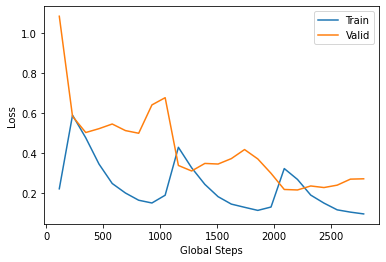

In [ ]:

train_loss_list, valid_loss_list, global_steps_list = load_metrics(cwd + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Evaluation

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, content), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                content = content.type(torch.LongTensor)  
                content = content.to(device)
                output = model(content, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Troll', 'Not Troll'])
    ax.yaxis.set_ticklabels(['Troll', 'Not Troll'])
    
best_model = BERT().to(device)

load_checkpoint(cwd + '/model.pt', best_model)

evaluate(best_model, test_iter)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/data/model.pt
